In [5]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [39]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [41]:
# reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)


C:\Users\Emilie\AppData\Local\Temp\ipykernel_34588\1929515567.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [44]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [46]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [48]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [55]:
# Find the most recent date in the data set.

session = Session(engine)
recentdate = session.query(func.max(Measurement.date)).scalar()
session.close()
recentdate

'2017-08-23'

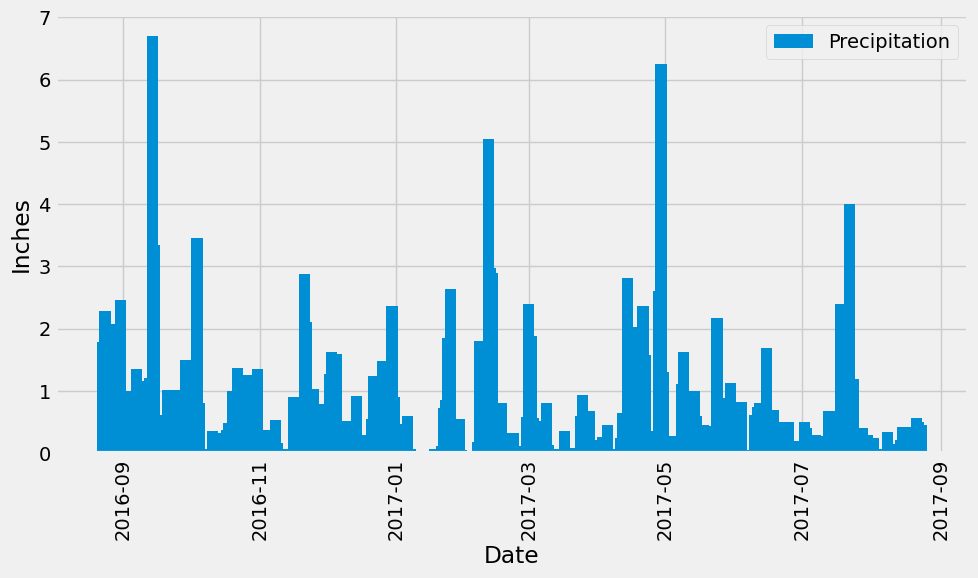

In [138]:
# Calculate the date one year from the last date in data set.
recentdate = pd.to_datetime(recentdate)  # Convert to datetime object
MinusYear =recentdate - pd.DateOffset(months=12)

# Convert datetime to string 
recentdate_str = recentdate.strftime('%Y-%m-%d')
MinusYear_str = MinusYear.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(func.strftime('%Y-%m-%d', Measurement.date), Measurement.prcp)\
    .filter(Measurement.date >= MinusYear_str)\
    .filter(Measurement.date <= recentdate_str)\
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df.sort_values(by='Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(pd.to_datetime(precipitation_df['Date']), precipitation_df['Precipitation'], width=5, label='Precipitation')
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [142]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [153]:
# Design a query to calculate the total number of stations in the dataset
session = Session(engine)
stationcount = session.query(func.count(Station.station)).scalar()
session.close()
stationcount

9

In [178]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                        .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.station).desc())\
                        .all()

# Print the results
for station, count in active_stations:
    print(station, count)


USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [182]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Get the station with the most stations from the previous query
most_active_station_id = active_stations[0][0]

temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)) \
                           .filter(Measurement.station == most_active_station_id) \
                           .all()

# Print the results
print(temperature_stats)

[(54.0, 85.0, 71.66378066378067)]


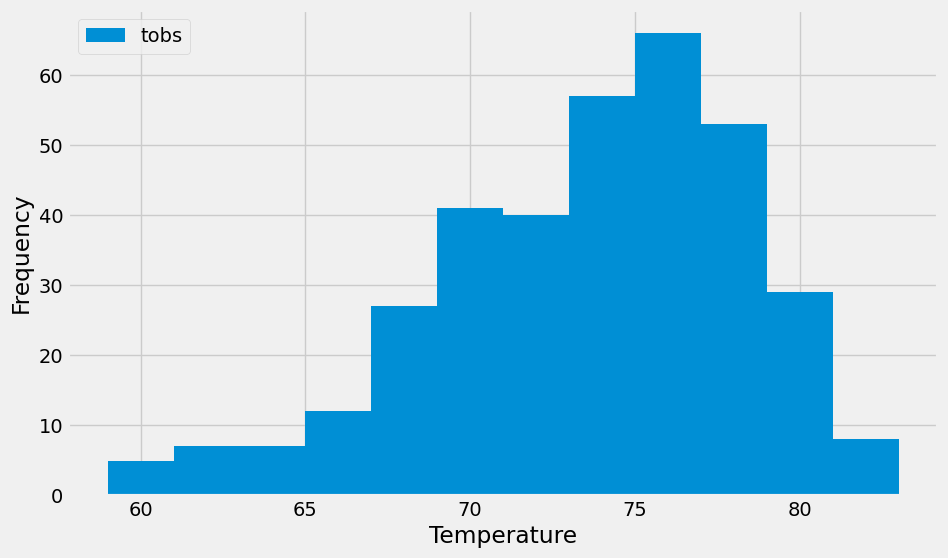

In [190]:
# Using the most active station id

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Convert the most recent date to a datetime object
most_recent_date = pd.to_datetime(recentdate)

# Calculate the date one year ago from the most recent date using pd.DateOffset
one_year_ago = most_recent_date - pd.DateOffset(years=1)

# Convert dates to string format
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')
most_recent_date_str = most_recent_date.strftime('%Y-%m-%d')

# Query the temperature observations for the most active station within the last 12 months
temperature_data = session.query(Measurement.date, Measurement.tobs)\
                          .filter(Measurement.station == most_active_station_id)\
                          .filter(Measurement.date >= one_year_ago_str)\
                          .filter(Measurement.date <= most_recent_date_str)\
                          .all()

# Convert the query result to a DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_df['Temperature'], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'], loc='upper left')
plt.grid(True)
plt.show()

# Close Session

In [192]:
# Close Session
session.close()